In [1]:
import MetaTrader5 as mt5
from utils.mt5_utils import create_dataframe

mt5.initialize()
df = create_dataframe(currency_pair='eurusd', timeframe="h1", years_back=1)

df

,open,high,low,close,tick_volume,spread
time,,,,,,
2023-04-10 15:00:00,1.08379,1.08472,1.08370,1.08387,1196,8
2023-04-10 16:00:00,1.08388,1.08518,1.08377,1.08471,675,8
2023-04-10 17:00:00,1.08473,1.08567,1.08473,1.08552,576,8
2023-04-10 18:00:00,1.08553,1.08590,1.08532,1.08588,567,8
2023-04-10 19:00:00,1.08588,1.08626,1.08547,1.08625,611,8
...,...,...,...,...,...,...
2024-09-04 10:00:00,1.10527,1.10555,1.10495,1.10527,1459,8
2024-09-04 11:00:00,1.10528,1.10537,1.10424,1.10498,1710,8
2024-09-04 12:00:00,1.10498,1.10523,1.10396,1.10520,2195,8


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8760 entries, 2023-04-10 15:00:00 to 2024-09-04 14:00:00
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   open         8760 non-null   float64
 1   high         8760 non-null   float64
 2   low          8760 non-null   float64
 3   close        8760 non-null   float64
 4   tick_volume  8760 non-null   uint64 
 5   spread       8760 non-null   int32  
dtypes: float64(4), int32(1), uint64(1)
memory usage: 444.8 KB


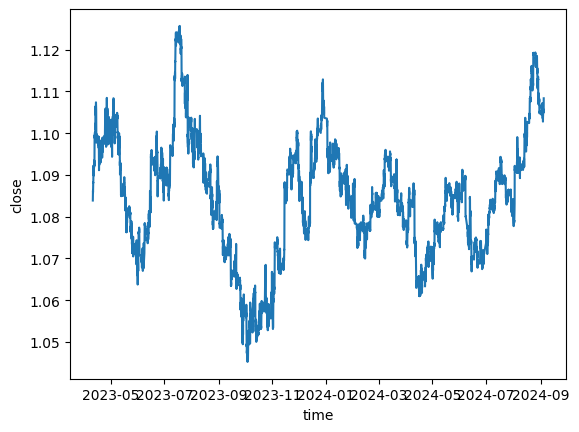

In [4]:
import seaborn as sns

sns.lineplot(data=df['close']);

In [5]:
import pandas as pd
df.index = pd.DatetimeIndex(df.index).to_period('h')

In [6]:
from pmdarima import auto_arima
arima_params = auto_arima(df[['close']], test='adf')
arima_params

c:\Users\User\trade\venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1898: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
c:\Users\User\trade\venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1905: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


ARIMA(order=(0, 1, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [7]:
from sklearn.model_selection import train_test_split
from statsmodels.tsa.arima.model import ARIMA

train, test = train_test_split(df, test_size=0.2, shuffle=False)

# ARIMA
arima_model = ARIMA(train['close'], order=(0,1,0))
arima = arima_model.fit()

c:\Users\User\trade\venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [8]:
arima_pred = arima.forecast(steps=len(test))
arima_pred

2024-01-27 15:00    1.08456
2024-01-27 16:00    1.08456
2024-01-27 17:00    1.08456
2024-01-27 18:00    1.08456
2024-01-27 19:00    1.08456
                     ...   
2024-04-09 10:00    1.08456
2024-04-09 11:00    1.08456
2024-04-09 12:00    1.08456
2024-04-09 13:00    1.08456
2024-04-09 14:00    1.08456
Freq: h, Name: predicted_mean, Length: 1752, dtype: float64

In [7]:
from sklearn.metrics import mean_squared_error

with_arima = mean_squared_error(test['close'], arima_pred)

print(f"MSE with ARIMA model: {with_arima}")


MSE with ARIMA model: 0.000180205714839885


In [11]:
import seaborn as sns
# sns.lineplot(df['close'])
df['close']

time
2023-04-10 15:00    1.08387
2023-04-10 16:00    1.08471
2023-04-10 17:00    1.08552
2023-04-10 18:00    1.08588
2023-04-10 19:00    1.08625
                     ...   
2024-09-04 10:00    1.10527
2024-09-04 11:00    1.10498
2024-09-04 12:00    1.10520
2024-09-04 13:00    1.10569
2024-09-04 14:00    1.10814
Freq: h, Name: close, Length: 8760, dtype: float64